# A2C

## About A2C

To understand A2C we must first understand what is A3C as A2C is bulit from A3C.

A3C was introduced in Deepmind’s paper “Asynchronous Methods for Deep Reinforcement Learning” (Mnih et al, 2016). In essence, A3C implements parallel training where multiple workers in parallel environments independently update a global value function—hence “asynchronous.” One key benefit of having asynchronous actors is effective and efficient exploration of the state space.

<img src='pic/A2C.png' alt="A2C" style='width: 500px;'/>

A2C is like A3C but without the asynchronous part; this means a single-worker variant of the A3C. It was empirically found that A2C produces comparable performance to A3C while being more efficient.

A2C, or Actor-Critic, is a reinforcement learning algorithm that uses a combination of policy-based and value-based methods to solve a problem. It uses two neural networks: an actor network and a critic network.

The actor network maps states to actions and is responsible for choosing actions to take in the environment. It outputs a probability distribution over the available actions, and an action is selected by sampling from this distribution. The actor network is updated to maximize the expected reward obtained by taking the chosen actions. This is done by computing the gradient of the expected reward with respect to the parameters of the actor network and updating the parameters in the direction of the gradient.

The critic network, on the other hand, evaluates the value of states and actions. It provides a value estimate of the current state, which represents the expected reward for that state. The critic network is updated based on the difference between its value estimate and the actual reward obtained after taking an action. This is known as temporal difference (TD) error and is used to update the critic network.

By using both an actor network and a critic network, A2C can balance exploration and exploitation in the environment. The actor network can explore the environment by trying out new actions, while the critic network can provide feedback on the expected reward of those actions. Over time, the actor network will learn to choose actions that maximize the expected reward, while the critic network will provide a more accurate value estimate.

In summary, A2C is a combination of policy-based and value-based methods that use two neural networks to balance exploration and exploitation in reinforcement learning.

## Library Imports

In [1]:
import numpy as np
import gym
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

## Model

In [2]:
class Model(tf.keras.Model):
    """Define the Actor Critic Model.
    This inherits from keras.Model. All layers should be defined in __init__.
    The forward pass is then defined in call() 
    Get  a action and a value for the state, call the get_action_value method
    """
    def __init__(self,num_action):
        super().__init__('mlp_policy')
        self.hidden_critic = kl.Dense(128,activation='relu')
        self.critic = kl.Dense(1,name='critic_logits') #aka value
        self.hidden_actor = kl.Dense(128,activation='relu')
        self.actor = kl.Dense(num_action,name='actor_logits') #aka policy


    def call(self,inputs):
        """This defines the forward pass in a keras model.
        The return of call are the outputs (but model.outputs can't be called when defining
        a model via subclassing). So this model has one input(states) and two outputs (actor and critc)
        """
        # inputs here are the states from action_value and an numpy array
        x = tf.convert_to_tensor(inputs)
        hidden_actor = self.hidden_actor(x)
        hidden_critic = self.hidden_critic(x)
        #the return here is equivalent to "outputs = " param in tf.keras.Model() method
        return self.actor(hidden_actor), self.critic(hidden_critic)
    

    def get_action_value(self, state):
        """Return the cation (from actor) and the value of the state(critic)
        This is the communication with the outer world: Given a state it 
        will return a action (probabilistic) and a state value estimate.
        This version only works in eager execution mode. See the following link
        for an explantion and a workarround for a graph compilable version:
        https://medium.com/@Inoryy/deep-reinforcement-learning-with-tensorflow-2-0-d8e62102680d
        """
        #executes call (see keras.Model object)
        actor,critic = self.predict(state, verbose = 0)
        #from the actor logits get the action
        action = tf.random.categorical(actor, 1) #for eager mode only
        return np.squeeze(action,axis=-1), np.squeeze(critic,axis=-1)

## A2C Agent

### Implementing A2C

<img src='pic/Formula.png' alt="A2C" style='width: 800px;'/>

The image above shows the Advantage function. On each learning step, we update both the Actor parameter (with policy gradients and advantage value), and the Critic parameter (with minimizing the mean squared error with the Bellman update equation).

In [3]:
class A2CAgent:
    def __init__(self,num_actions):
        self.GAMMA = 0.99
        self.VALUE_LOSS_FACTOR = 0.5
        self.ENTROPY_FACTOR = 0.0001
        self.LEARNING_RATE = 0.001
        self.num_actions = num_actions
        
        self.model = Model(num_action = self.num_actions)
        self.model.compile(
            optimizer = ko.RMSprop(lr=self.LEARNING_RATE),
            loss = [self._actor_loss, self._critic_loss]
        )

    def train(self,states, state_values,actions,rewards,dones,next_state):
        """Trains the actor and critic based on new episode(s) data
        This is the with 
        The actor requires a state as input and actions and thier advantges for the loss.
        The critic requires a state as input and just the returns to calculate the loss.
        """
        #generate discounted rewards (returns) and advantages
        _, next_state_value = self.model.get_action_value(next_state[None,:])
        returns,advantages = self._returns_advantages(rewards,dones,state_values,next_state_value)
        #concateneate. A trick to use "default" loss definition. Alternativly, a loss
        #function would need to be encapsuled inside another loss function if it uses more than
        #2 parameters. See Keras docs
        actions_and_advantages = np.concatenate([actions[:, None], advantages[:, None]], axis=-1)
        #train_on_batch takes x and y as parameters. y in our case is two dimensional (actor logits and
        # critic logits), hence we requre the y (=y_true) for both actor and critic output
        loss = self.model.train_on_batch(states,[actions_and_advantages,returns])
        return loss
    

    def _returns_advantages(self,rewards,dones,state_values,next_state_value):
        """Calculated discounted returns and the advantages.
        Advantages are required for the loss of the actor, the discounted returns for the critic.
        returns:
            :returns:       discoutned retunrs
            :advantages:    how much better is the return(from a certain action) than the estimated
                            value of the state
        """
        returns = np.append(np.zeros_like(rewards), next_state_value, axis=-1)
        # returns are calculated as discounted sum of future rewards
        for t in reversed(range(len(rewards))):
            returns[t] = rewards[t] + self.GAMMA * returns[t+1] * (1-dones[t])
        returns = returns[:-1]
        #advantages are the returns - the esimated value of the state (critic)
        advantages = returns - state_values
        return returns,advantages
    

    def _critic_loss(self,returns,critic_logits):
        """The custom loss function for the critic.
        Keras always reuqires  a fucntion with two parameters y_true (targets) and y_pred (output,logits). 
        Y_true is what is put in for reference and y_pred is what is defined as model output. 
        In this case, the y_true is returns and the y_pred is the predicted value which
        is given by the critic logits.
        """
        return self.VALUE_LOSS_FACTOR * kls.mean_squared_error(returns,critic_logits)
    

    def _actor_loss(self, acts_and_advs, actor_logits):
        """The custom loss function for the actor
        For explanation of how tf/keras calls it, see critic loss above and reference.
        y_true = targets are actions and advantages. The y_pred = policy = output (logits) of 
        the actor network (not normalized)
        """
        actions, advantages = tf.split(acts_and_advs, 2, axis = -1)
        # sparse categorical CE loss obj that supports sample_weight arg on call()
        # from_logits argument ensures transformation into normalized probabilities
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # policy loss is defined by policy gradients, weighted by advantages
        # note: we only calculate the loss on the actions we've actually taken
        # that and because A2C is on policy method is the reason why policy gardients
        # ususally require many episodeds to converge
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions,actor_logits,sample_weight = advantages)
        # entropy loss can be calculated via CE over itself
        entropy_loss = kls.categorical_crossentropy(actor_logits, actor_logits, from_logits=True)
        #signs are flipped because optimizer minimizes
        return policy_loss - self.ENTROPY_FACTOR * entropy_loss
    
    def get_action_value(self, state):
        """Returns action and value given a state. 
        Just path though to the model. It is defined here so that there is a clear
        agent <--> env only communication without cross references to the model underlying 
        the agent.
        """
        return self.model.get_action_value(state)

## Running

C:\Users\p2123037\.conda\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
INFO:root:Episode: 9, Reward: -191.80280115077863
INFO:root:Episode: 19, Reward: -228.12794022736293
INFO:root:Episode: 29, Reward: -238.73409951615128
INFO:root:Episode: 39, Reward: -208.97581048928163
INFO:root:Episode: 49, Reward: -173.0943438470036
INFO:root:Episode: 59, Reward: -150.04698716207466
INFO:root:Episode: 69, Reward: -154.09966090021254
INFO:root:Episode: 79, Reward: -188.54258485780258
INFO:root:Episode: 89, Reward: -125.91101893599577
INFO:root:Episode: 99, Reward: -150.54270583067324
INFO:root:Episode: 109, Reward: -126.22597124262475
INFO:root:Episode: 119, Reward: -145.83528083312066
INFO:root:Episode: 129, Reward: -134.014271159802
INFO:root:Episode: 139, Reward: -124.30821623888532
INFO:root:Episode: 149, Reward: -136.5256616419117
INFO:root:Episode: 159,

Finished training.


C:\Users\p2123037\AppData\Local\Temp\ipykernel_25756\1519843411.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


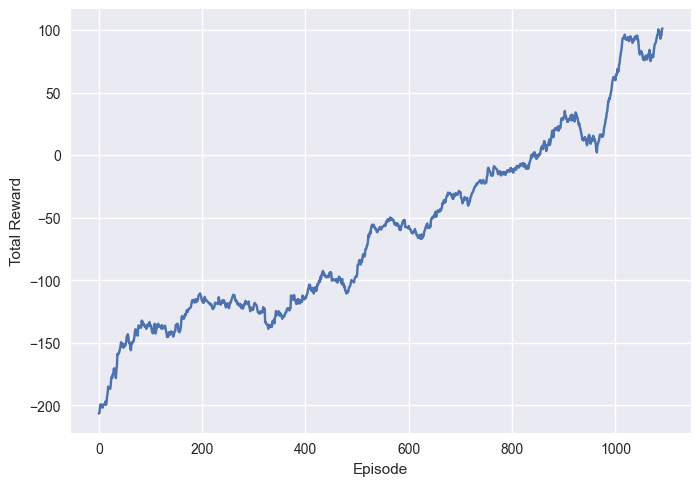

In [4]:
#constants
ENV_NAME = 'LunarLander-v2'
BATCH_SIZE = 64
UPDATES = 6000 #number of training sessions (updates) in total. 
RENDER_EVERY = 1000 # render every nth episode

#init env and agent. 
logging.getLogger().setLevel(logging.INFO)
env = gym.make(ENV_NAME)
agent = A2CAgent(env.action_space.n)

#init variabls for the training loops
states  = np.zeros((BATCH_SIZE, env.observation_space.shape[0]))
actions = np.zeros(BATCH_SIZE, dtype=np.int32)
rewards = np.zeros(BATCH_SIZE)
dones   = np.zeros(BATCH_SIZE)
state_values  = np.zeros(BATCH_SIZE)
episode_reward_lst = [0.0]
next_state = env.reset()
#loop though N training steps
for update in range(UPDATES):
    #gather BATCH_SIZE trajectories (SARS' paris)
    for step in range(BATCH_SIZE):
        states[step] = next_state.copy()
        actions[step], state_values[step] = agent.get_action_value(next_state[None, :])
        if len(episode_reward_lst) % RENDER_EVERY == 0: 
            env.render()
        next_state, rewards[step], dones[step], _ = env.step(actions[step])
        episode_reward_lst[-1] += rewards[step]
        if dones[step]:
            episode_reward_lst.append(0.0)
            next_state = env.reset()
            if len(episode_reward_lst) % 10 == 0:
                logging.info(f"Episode: {len(episode_reward_lst)-1}, Reward: {np.mean(episode_reward_lst[-12:-2])}")
    agent.train(states, state_values,actions,rewards,dones,next_state)
        
print("Finished training.")
#make simple moving average over 50 episodes (smoothing) and plot
SMA_rewards = np.convolve(episode_reward_lst, np.ones((50,))/50, mode='valid')
plt.style.use('seaborn')
plt.plot(SMA_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

From the plot above we note that:
- There is an increasing trend 
- The reward never reached above 200 which is our goal
- Stopped early as the reward was no longer increasing